#Анализ товарного ассортимента магазина

## Цель

Провести анализ товарного ассортимента и определить какие товары входят в основной и дополнительный ассортимент.

### Описание данных
|Признак | Комментарий|
|--:|:--|
|`date` | дата заказа|
|`customer_id` | идентификатор покупателя|
|`order_id` | идентификатор заказа|
|`product` | наименование товара|
|`quantity` | количество товара в заказе|
|`price` | цена товара|

Примерный план

Шаг 1. Загрузка данных
- Загрузка данных и предварительный анализ

Шаг 2. Подготовка данных (при необходимости)
- Корректировка заголовков;
- Корректировка типов признаков;
- Поиск дублей, аномальных и пропущенных значений;
- Добавление новых столбцов.

Шаг 3. Исследовательский анализ данных
- Построить диаграмму количества покупок по дням;
- Построить диаграмму, отображающую сумму покупок по дням;
- Построить гистограмму, отображающую распределение заказов по сумме.

Шаг 4. Анализ торгового асортимента
- На основании наименования товара и данных открытых внешних источников предложить 3-10 категорий товаров;
- В каждой категории распределить товары на основной и дополнительный ассортимент.

Шаг 5. Статистические гипотезы
- Сформулировать и проверить статистические гипотезы о равенстве средних чеков для выделенных категорий товаров.

# Подключение библиотек

In [386]:
import pandas as pd
import numpy as np

from datetime import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats as st


# Блок пользовательских функций


In [387]:
def calc_boxplot(df_col : pd.Series) -> tuple:

    """
    Функция для расчета значений нижнего и верхнего усов.
    На вход подается столбец датафрейма,
    на выходе кортеж: первый элемент -- нижний ус, второй элемент -- верхний ус
    """

    Q1, median, Q3 = np.percentile(np.asarray(df_col.dropna()), [25, 50, 75])
    IQR = Q3 - Q1
    loval = Q1 - 1.5 * IQR
    hival = Q3 + 1.5 * IQR
    wiskhi = np.compress(np.asarray(df_col.dropna()) <= hival,
                         np.asarray(df_col.dropna()))
    wisklo = np.compress(np.asarray(df_col.dropna()) >= loval,
                         np.asarray(df_col.dropna()))
    actual_hival = np.max(wiskhi)
    actual_loval = np.min(wisklo)
    return actual_loval, actual_hival #(нижний ус, верхний ус)

In [388]:
def get_category_key(text) -> str:
  """
  Функция для поиска ключа в строке.
  На вход подается значения словаря.
  На выходе получаем название категории в виде строки.
  """
  for key, substrings in dct_category.items():
      for sub in substrings:
          if sub in text:  # Проверка частичного вхождения подстроки
              return key
  return 'Неизвестная категория' # Значение по умолчанию, если ничего не найдено

In [389]:

def assign_abc_group(cum_share: float) -> str:
  """
  Функция для определения группы товара в зависимости от доли продаж.
  На вход подается число - накопленная доля продаж по категории.
  На выход получаем строку - название группы товара (A/B/C).
  """
  if cum_share <= 80:
      return 'A'
  elif cum_share <= 95:
      return 'B'
  else:
      return 'C'

In [390]:
def define_type(row: str) -> str:
  """
  Функция для определения категории ассортимента.
  На вход подается строка - значение категории (A/B/C).
  На выходе получаем строку - название категории ассортимента.
  """
  if row['abc_group'] == 'A':
      return 'Основной'
  else:
      return 'Дополнительный'

In [391]:
def check_hyp(x, alpha:float=0.05):
  """
  Функция для проверки нормальности распределения значений.
  на вход подается значение переменной x и уровень значимости alpha,
  на выходе получаем вывод о том, принимаем или отвергаем сформулированную
  гипотезу.
  """
  stat_emp, p_value = shapiro(x, nan_policy='omit')
  print('Критерий Шапиро')
  if p_value < alpha:
      print(f"""Гипотезу H_0 о нормальном распределении x отвергаем.
        Иными словами, распределение сл. величины x отлично от нормального.
        p-value = {p_value}""")
  else:
      print(f"""Гипотезу H_0 о нормальном распределении x примимаем.
        Иными словами, распределение сл. величины x нормальное.
        p-value = {p_value}""")

In [392]:
def check_ks(x, alpha:float=0.05):
  """
  Функция для проверки различий между распределениями -- выборка против
  теоретического закона.
  на вход подается значение переменной x и уровень значимости alpha,
  на выходе получаем вывод о том, принимаем или отвергаем сформулированную
  гипотезу.
  """
  stat_emp, p_value = kstest(x,
                               cdf=(x.mean(), x.std()),
                               nan_policy='omit'
                               )
  print('Критерий Колмогорова-Смирнова')
  if p_value < alpha:
      print(f"""Гипотезу H_0 о нормальном распределении x отвергаем.
        Иными словами, распределение сл. величины x отлично от нормального.
        p-value = {p_value}""")
  else:
      print(f"""Гипотезу H_0 о нормальном распределении x принимаем.
        Иными словами, распределение сл. величины x нормальное.
        p-value = {p_value}""")

#Загрузка данных

In [393]:
df = pd.read_csv('/content/sample_data/vkr_project_retail.csv')
df.head(3)

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0


In [394]:
unique_values = df.nunique()
print(f'''Количество уникальных значений по признакам
{unique_values}''')

Количество уникальных значений по признакам
date           2606
customer_id    2451
order_id       2784
product        2343
quantity         49
price           360
dtype: int64


In [395]:
df.info

<bound method DataFrame.info of             date                           customer_id  order_id  \
0     2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
1     2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
2     2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
3     2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
4     2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
...          ...                                   ...       ...   
6732  2019103111  73d1cd35-5e5f-4629-8cf2-3fda829d4e58     73156   
6733  2019103112  1f0a7f35-7459-4f23-b468-5e45bf481dd1     73158   
6734  2019103113  25df96a7-c453-4708-9cea-a3dfc7c342ea     73162   
6735  2019103114  73d1cd35-5e5f-4629-8cf2-3fda829d4e58     73164   
6736  2019103116  344aa778-e436-419e-a9c6-9b8f37b7c1df     73137   

                                                product  quantity   price  
0       Комнатное растение в горшке Алое Вера, d12, h30         1   142.0  
1     Комнатное растение в горшке Кофе Арабика, d12,...         1   194.0  
2                           Радермахера d-12 см h-20 см         1   112.0  
3                      Хризолидокарпус Лутесценс d-9 см         1   179.0  
4                        Циперус Зумула d-12 см h-25 см         1   112.0  
...                                                 ...       ...     ...  
6732  Таз пластмассовый 40,0 л пищевой овальный (Иж)...         1   404.0  
6733         Сумка-тележка 2-х колесная Gimi Argo синяя         1  1087.0  
6734  Герань домашняя (пеларгония зональная) цветуща...         1   157.0  
6735  Таз пластмассовый со стиральной доской (Иж), 1...         1   397.0  
6736         Сумка-тележка 2-х колесная Gimi Argo синяя         1  1087.0  

[6737 rows x 6 columns]>

In [396]:
# описательные статистики

perc = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
df.describe(percentiles=perc)

,date,order_id,quantity,price
count,6.737000e+03,6737.000000,6737.000000,6737.000000
mean,2.018855e+09,43128.948345,2.501559,462.028499
std,3.855185e+05,27899.414662,15.266478,871.296064
min,2.018100e+09,12624.000000,1.000000,9.000000
1%,2.018100e+09,14498.000000,1.000000,15.000000
5%,2.018102e+09,14553.800000,1.000000,38.000000
25%,2.019020e+09,14827.000000,1.000000,101.000000
50%,2.019050e+09,68503.000000,1.000000,135.000000
75%,2.019061e+09,70504.000000,1.000000,398.000000
95%,2.019092e+09,72616.200000,6.000000,1949.000000


## Выводы

Данные загружены корректно
|Признак|Комментарий|
|--:|:--|
|`date`|привести дату к нормальному виду|
|`quantity`|имеются аномальные значения, возможно, следует выделить данные отдельно|


# Предварительная обработка данных


##Корректировка заголовков

In [397]:
df.rename(columns={'product': 'product_name',
           'quantity': 'quantity_in_order'}, inplace=True)
df.columns

Index(['date', 'customer_id', 'order_id', 'product_name', 'quantity_in_order',
       'price'],
      dtype='object')

##Поиск дублей

In [398]:
total_rows = len(df)

unique_rows = len(df.drop_duplicates())

non_unique_rows = total_rows - unique_rows

percentage_non_unique = (non_unique_rows / total_rows) * 100

print("Процент дублей составляет: {:.2f}%".format(percentage_non_unique))


Процент дублей составляет: 0.00%


##Преобразование даты

In [399]:
# для приведения даты к нормальному виду сначала преобразуем серию в строку

df['date'] = df['date'].astype(str)
print(df.dtypes)
print('----------------')
df['date'] = df['date'].apply(lambda x: dt.strptime(x, '%Y%m%d%H'))
print("\nDataFrame после преобразования:")
print(df.head(3))

date                  object
customer_id           object
order_id               int64
product_name          object
quantity_in_order      int64
price                float64
dtype: object
----------------

DataFrame после преобразования:
        date                           customer_id  order_id  \
0 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
1 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
2 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   

                                        product_name  quantity_in_order  price  
0    Комнатное растение в горшке Алое Вера, d12, h30                  1  142.0  
1  Комнатное растение в горшке Кофе Арабика, d12,...                  1  194.0  
2                        Радермахера d-12 см h-20 см                  1  112.0  


In [400]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               6737 non-null   datetime64[ns]
 1   customer_id        6737 non-null   object        
 2   order_id           6737 non-null   int64         
 3   product_name       6737 non-null   object        
 4   quantity_in_order  6737 non-null   int64         
 5   price              6737 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 315.9+ KB


##Поиск пропущенных значений

In [401]:
print(f'''Количество пропусков по столбцам:
{df.isnull().sum()}''')

Количество пропусков по столбцам:
date                 0
customer_id          0
order_id             0
product_name         0
quantity_in_order    0
price                0
dtype: int64


##Добавление новых столбцов

In [402]:
# дата_заказа
df['days_orders'] = df['date'].dt.date

# сумма покупок в заказе

df['sum_orders'] = (df['price'] * df['quantity_in_order'])

df.columns

Index(['date', 'customer_id', 'order_id', 'product_name', 'quantity_in_order',
       'price', 'days_orders', 'sum_orders'],
      dtype='object')

##Поиск и обработка аномальных значений

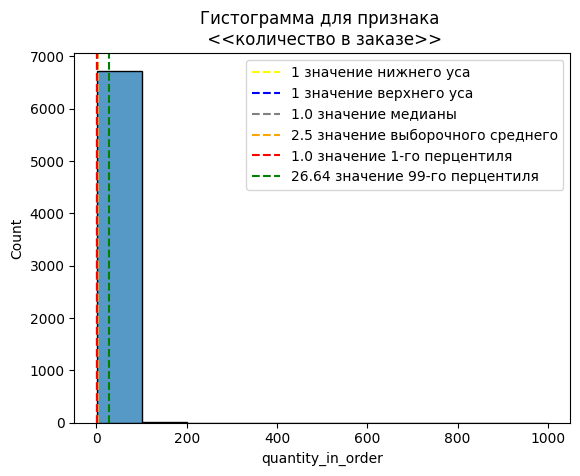

In [403]:
# для признака "количество в заказе"

ax1 = sns.histplot(df['quantity_in_order'], bins=10)

plt.title(f'Гистограмма для признака \n <<количество в заказе>>')

# расчет и визуализация "усов"
low_wish, hi_wish = calc_boxplot(df['quantity_in_order'])
ax1.axvline(low_wish,
              color='yellow',
              linestyle='dashed',
              label=f'{np.round(low_wish,1)} значение нижнего уса')
ax1.axvline(hi_wish,
              color='blue',
              linestyle='dashed',
              label=f'{np.round(hi_wish,1)} значение верхнего уса')

# расчет и визуализация медианы и выб.среднего

ax1.axvline(df['quantity_in_order'].median(),
              color='grey',
              linestyle='dashed',
              label=f'{(df['quantity_in_order'].median())} значение медианы')
ax1.axvline(df['quantity_in_order'].mean(),
              color='orange',
              linestyle='dashed',
              label=f'{(df['quantity_in_order'].mean()).round(2)} значение выборочного среднего')

#расчет и визуализация перцентелей
per_1 = (np.nanpercentile(df['quantity_in_order'], 1)).round(2)
per_99 = (np.nanpercentile(df['quantity_in_order'], 99)).round(2)
ax1.axvline(per_1, color='red',
                      linestyle='dashed',
                      label=f'{per_1} значение 1-го перцентиля')
ax1.axvline(per_99,
              color='green',
              linestyle='dashed',
              label=f'{per_99} значение 99-го перцентиля')

plt.legend()

По графику видно, что значения "усов", медиана, 1-перцентиль и выборочное среднее почти совпадают,  
        в отличие от 99-го перцентиля.   
Вероятно, это были какие-то оптовые заказы, можно выделить эти записи отдельно.

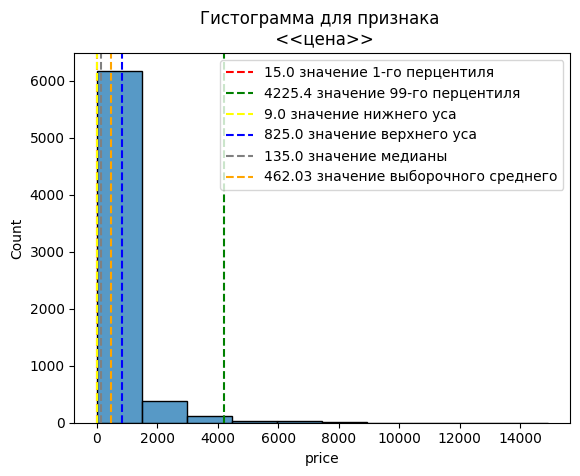

In [404]:
# для признака "цена"
ax1 = sns.histplot(df['price'], bins=10)

plt.title(f'Гистограмма для признака \n <<цена>>')
per_1 = (np.nanpercentile(df['price'], 1)).round(2)
per_99 = (np.nanpercentile(df['price'], 99)).round(2)


#расчет и визуализация перцентелей
ax1.axvline(per_1, color='red',
                      linestyle='dashed',
                      label=f'{per_1} значение 1-го перцентиля')
ax1.axvline(per_99,
              color='green',
              linestyle='dashed',
              label=f'{per_99} значение 99-го перцентиля')
# расчет и визуализация "усов"
low_wish, hi_wish = calc_boxplot(df['price'])
ax1.axvline(low_wish,
              color='yellow',
              linestyle='dashed',
              label=f'{np.round(low_wish,1)} значение нижнего уса')
ax1.axvline(hi_wish,
              color='blue',
              linestyle='dashed',
              label=f'{np.round(hi_wish,1)} значение верхнего уса')

# расчет и визуализация медианы и выб.среднего

ax1.axvline(df['price'].median(),
              color='grey',
              linestyle='dashed',
              label=f'{(df['price'].median())} значение медианы')
ax1.axvline(df['price'].mean(),
              color='orange',
              linestyle='dashed',
              label=f'{(df['price'].mean()).round(2)} значение выборочного среднего')


plt.legend()

На графике видно, что есть выбросы, значение 99-го перцентиля
  явно выделяется
  среди прочих показателей,
можно также выделить эти данные и рассмотреть отдельно.

In [405]:
# напишем фильтр для выделения аномальных значений в отдельный датафрейм
filt = (
        (df['quantity_in_order'].between(calc_boxplot(df['quantity_in_order'])[0],
                              np.nanpercentile(df['quantity_in_order'] ,99)))
        &
        (df['price'].between(calc_boxplot(df['price'])[0],
                  np.nanpercentile(df['price'] ,99))))

In [406]:
# оценим % потерь

print(f'''Процент потери данных, если убрать аномалии, составит:
{np.round((1 - df.loc[filt].shape[0]/df.shape[0]) * 100)}%''')

Процент потери данных, если убрать аномалии, составит:
2.0%


In [407]:
# аномальные данные
df_anomals = df.loc[~filt]

# очищенные данные
df_clear = df.loc[filt]

In [408]:
df_clear.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6601 entries, 0 to 6736
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               6601 non-null   datetime64[ns]
 1   customer_id        6601 non-null   object        
 2   order_id           6601 non-null   int64         
 3   product_name       6601 non-null   object        
 4   quantity_in_order  6601 non-null   int64         
 5   price              6601 non-null   float64       
 6   days_orders        6601 non-null   object        
 7   sum_orders         6601 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 464.1+ KB


In [409]:
# выделим отдельно записи с "большими" заказами
df_big_orders = df[df['quantity_in_order'] > 26]
df_big_orders.head(2)

,date,customer_id,order_id,product_name,quantity_in_order,price,days_orders,sum_orders
13,2018-10-01 15:00:00,0948b0c2-990b-4a11-b835-69ac4714b21d,68486,Крючок одежный 2-х рожковый серый металлик с п...,96,38.0,2018-10-01,3648.0
144,2018-10-08 15:00:00,9151d307-654c-4239-a888-ada5ca45f0b2,68571,Набор вешалок для костюма 45см 4шт цвет: кремо...,37,202.0,2018-10-08,7474.0


In [410]:
# сгруппируем большие заказы по id заказа, наименованию товара и выведем
# общее кол-во в заказе, и сумму

df_big_orders_group =  (df_big_orders.groupby(['order_id', 'product_name']))
df_big_orders_count =  (((df_big_orders_group[['quantity_in_order', 'sum_orders']]
                                            .sum())
                                            .sort_values(by='quantity_in_order',
                                                         ascending=False))
                                            .reset_index())
df_big_orders_count.head(10)

,order_id,product_name,quantity_in_order,sum_orders
0,71743,"Вантуз с деревянной ручкой d14 см красный, Bur...",1000,675000.0
1,71668,Вешалки мягкие для деликатных вещей 3 шт шоколад,334,49432.0
2,71478,Муляж ЯБЛОКО 9 см красное,300,15300.0
3,68611,"Крепеж для пружины дверной, 1107055",300,5700.0
4,68611,Пружина дверная 240 мм оцинкованная (Д-19 мм) ...,300,11400.0
5,69289,"Ручка-скоба РС-100 белая *Трибатрон*, 1108035",200,5800.0
6,68815,Муляж ЯБЛОКО 9 см красное,170,8670.0
7,72845,Муляж Яблоко зеленый 9 см полиуретан,160,9440.0
8,70841,Плечики пластмассовые Размер 52 - 54 Тула 1205158,150,3000.0
9,68831,Муляж ЯБЛОКО 9 см красное,140,8260.0


##Выводы


Проведены следующие работы:

- скорретированы заголовки признаков;
- приведены значения Даты к нормальному виду;
- дублирующихся записей и пропусков нет;
- добавлены новые переменные;
- на основе анализа распределений непрерывных признаков относительно значений нижней и верхней границ boxplot, а также 1-го и 99-го перцентиля, составлен фильтр для выявления аномалий;
- на основе фильтра выделены 3 набора данных: набор очищенных данных, набор аномальных данных, набор данных с большими заказами.

# Исследовательский анализ

In [411]:
df_clear.head(2)

,date,customer_id,order_id,product_name,quantity_in_order,price,days_orders,sum_orders
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018-10-01,142.0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,2018-10-01,194.0


## Распределение количества покупок по дням

In [412]:
df_count_orders = (
    df_clear.groupby('days_orders')
            .agg(count_orders=('order_id', 'count'))
            .reset_index())
df_count_orders;


df_count_orders_big = (
    df_big_orders.groupby('days_orders')
            .agg(count_orders=('order_id', 'count'))
            .reset_index())
df_count_orders_big;

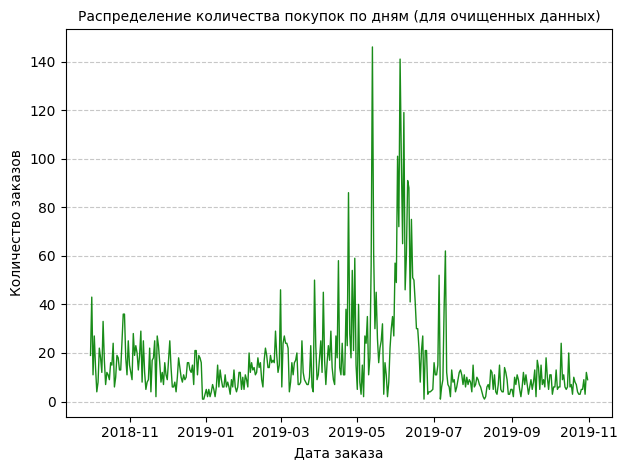

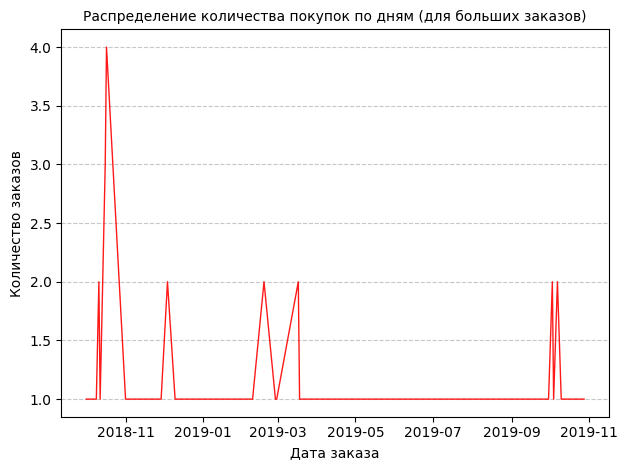

In [413]:
ax1 = sns.lineplot(
                 data=df_count_orders,
                 x='days_orders',
                 y='count_orders',
                 alpha=0.9,
                 linewidth=1,
                 color='green')

ax1.grid(axis='y', linestyle='--', alpha=0.7)

ax1 = plt.title('Распределение количества покупок по дням (для очищенных данных)',
          fontsize=10)
ax1 = plt.xlabel('Дата заказа', fontsize=10)
ax1 = plt.ylabel('Количество заказов', fontsize=10)

ax1 = plt.tight_layout()
ax1 = plt.show()


ax2 = sns.lineplot(
                 data=df_count_orders_big,
                 x='days_orders',
                 y='count_orders',
                 alpha=0.9,
                 linewidth=1,
                 color='red')

ax2.grid(axis='y', linestyle='--', alpha=0.7)

ax2 = plt.title('Распределение количества покупок по дням (для больших заказов)',
          fontsize=10)
ax2 = plt.xlabel('Дата заказа', fontsize=10)
ax2 = plt.ylabel('Количество заказов', fontsize=10)

ax2 = plt.tight_layout()
ax2 = plt.show()

##Распределение суммы покупок по дням

In [414]:
df_sum_orders = (
    df_clear.groupby('days_orders')
            .agg(sum_orders=('sum_orders', 'sum'))
            .reset_index())
df_sum_orders;

df_sum_orders_big = (
    df_big_orders.groupby('days_orders')
            .agg(sum_orders=('sum_orders', 'sum'))
            .reset_index())
df_sum_orders_big;

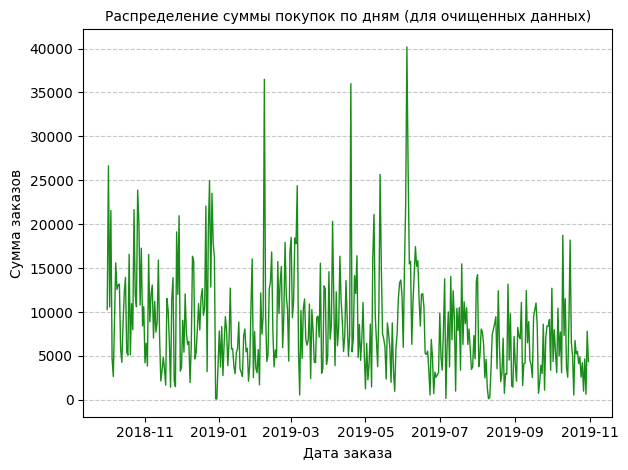

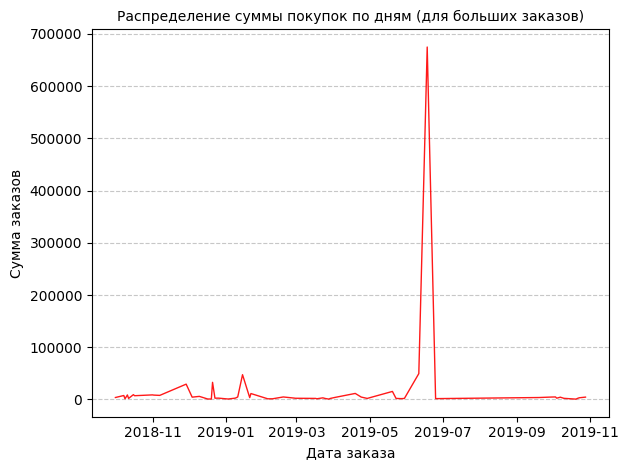

In [415]:
ax1 = sns.lineplot(
                 data=df_sum_orders,
                 x='days_orders',
                 y='sum_orders',
                 alpha=0.9,
                 linewidth=1,
                 color='green')

ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1 = plt.title('Распределение суммы покупок по дням (для очищенных данных)',
              fontsize=10)
ax1 = plt.xlabel('Дата заказа', fontsize=10)
ax1 = plt.ylabel('Сумма заказов', fontsize=10)
ax1 = plt.tight_layout()
ax1 = plt.show()


ax2 = sns.lineplot(
                 data=df_sum_orders_big,
                 x='days_orders',
                 y='sum_orders',
                 alpha=0.9,
                 linewidth=1,
                 color='red')

ax2.grid(axis='y', linestyle='--', alpha=0.7)
ax2 = plt.title('Распределение суммы покупок по дням (для больших заказов)',
                fontsize=10)
ax2 = plt.xlabel('Дата заказа', fontsize=10)
ax2 = plt.ylabel('Сумма заказов', fontsize=10)
ax2 = plt.tight_layout()
ax2 = plt.show()

##Распределение заказов по сумме

In [416]:
df_sum_count_orders = (
    df_clear.groupby('sum_orders')
            .agg(count_orders=('order_id', 'count'))
            .reset_index())
df_sum_count_orders;


df_sum_count_orders_big = (
    df_big_orders.groupby('sum_orders')
            .agg(count_orders=('order_id', 'count'))
            .reset_index())
df_sum_count_orders_big;

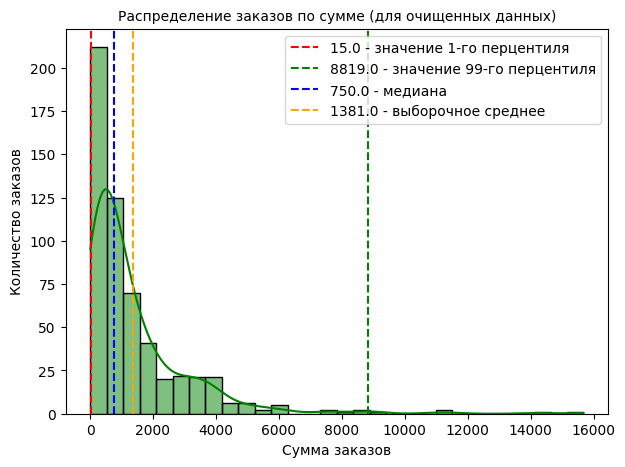

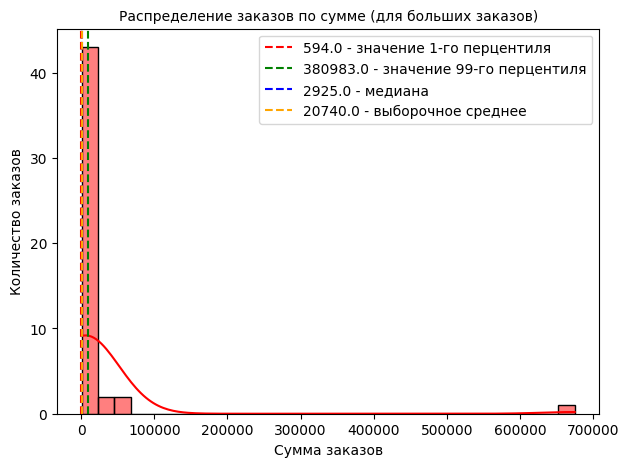

In [417]:
ax1 = plt.figure(figsize=(7,5))
ax1 = sns.histplot(df_sum_count_orders['sum_orders'],
                   bins=30, kde=True, color='green')

per_1 = (np.nanpercentile(df_sum_count_orders['sum_orders'], 1)).round()
per_99 = (np.nanpercentile(df_sum_count_orders['sum_orders'], 99)).round()
median = (df_sum_count_orders['sum_orders'].median())
mean_sum = (df_sum_count_orders['sum_orders'].mean()).round()


ax1.axvline(per_1, color='red',linestyle='dashed',
                   label=f'{per_1} - значение 1-го перцентиля')
ax1.axvline(per_99, color='green', linestyle='dashed',
                    label=f'{per_99} - значение 99-го перцентиля')
ax1.axvline(median, color='blue', linestyle='dashed',
                    label=f'{median} - медиана')
ax1.axvline(mean_sum, color='orange', linestyle='dashed',
                      label=f'{mean_sum} - выборочное среднее')


ax1 = plt.title('Распределение заказов по сумме (для очищенных данных)',
                fontsize=10)
ax1 = plt.xlabel('Сумма заказов', fontsize=10)
ax1 = plt.ylabel('Количество заказов', fontsize=10)
ax1 = plt.legend()


ax2 = plt.figure(figsize=(7,5))
ax2 = sns.histplot(df_sum_count_orders_big['sum_orders'],
                   bins=30, kde=True, color='red')


per_1_b = (np.nanpercentile(df_sum_count_orders_big['sum_orders'], 1)).round()
per_99_b = (np.nanpercentile(df_sum_count_orders_big['sum_orders'], 99)).round()
median_b = (df_sum_count_orders_big['sum_orders'].median())
mean_sum_b = (df_sum_count_orders_big['sum_orders'].mean()).round()

ax2.axvline(per_1, color='red', linestyle='dashed',
                   label=f'{per_1_b} - значение 1-го перцентиля')
ax2.axvline(per_99, color='green', linestyle='dashed',
                    label=f'{per_99_b} - значение 99-го перцентиля')
ax2.axvline(median, color='blue', linestyle='dashed',
                    label=f'{median_b} - медиана')
ax2.axvline(mean_sum, color='orange', linestyle='dashed',
                     label=f'{mean_sum_b} - выборочное среднее')

ax2 = plt.title('Распределение заказов по сумме (для больших заказов)',
                fontsize=10)
ax2 = plt.xlabel('Сумма заказов', fontsize=10)
ax2 = plt.ylabel('Количество заказов', fontsize=10)
ax2 = plt.legend()

##Выводы



- были проанализированы 2 набора данных:

  - в **df_clear** содержатся данные о заказах за вычетом аномальных значений;

  - в **df_big_orders** выделены данные по большим отгрузкам;

- в очищенных данных распределение суммы покупок по дням и распределение количества покупок по дням почти равномерное, в отличие от данных с большими
заказами. Там, вероятнее всего, были оптовые отгрузки клиентам;

- глядя на распределение заказов по сумме, видно, что большая часть заказов не превышает 1500 рублей. На гистограмме с данными о больших заказах, большая часть не превышает 20000 руб.


# Анализ товарного ассортимента

In [418]:
# рассмотрим отдельно категориальный признак "наименование продукта"

print(f'''Количество уникальных наименований = {df.product_name.nunique()}''')

Количество уникальных наименований = 2343


In [419]:
# так как уникальных наименований более 2000, попробуем разбить их
# на ключевые слова (по первому слову), и посчитать их кол-во

df['first_word_product'] = df['product_name'].str.split().str[0]

df.first_word_product.value_counts()


,count
first_word_product,
Рассада,1372
Пеларгония,797
Сумка-тележка,337
Сушилка,310
Муляж,207
...,...
Основание,1
Мерный,1
Стяжки,1


##Этапы работ для определения товарной категории

1 -- Создать список товаров по первому слову в наименовании,
преобразовать его во множество, чтобы избавиться от дубликатов, и вернуть обратно в список;

2 -- С помощью срезов рассмотреть значения списка, чтобы сформировать категории;

3 -- Создать список ключей для категорий, которые в дальнейшем будут присвоены каждому товару, а также списки значений для каждого ключа;

4 -- Создать словарь из списков и с помощью него добавить новый столбец с названиями категорий товаров.


In [420]:
lst_products = df.first_word_product.to_list()

set_products = set(lst_products)

unique_lst_products = list(set_products)

print(f'''Количество уникальных наименований
по первому слову (ключу) -- {len(unique_lst_products)}''')

Количество уникальных наименований
по первому слову (ключу) -- 461


In [421]:
# воспользуемся срезами, чтобы изучить подробнее элементы списка
unique_lst_products[:5]

['Урна-пепельница', 'Анемона', 'Ёрш', 'Пена', 'Настольная']

In [422]:
# список ключей для категорий
lst_category_keys = ['Посуда и кухонные принадлежности',
                     'Все для ремонта',
                     'Цветы, растения',
                     'Хозтовары',
                     'Бытовая химия']

lst_category_keys

['Посуда и кухонные принадлежности',
 'Все для ремонта',
 'Цветы, растения',
 'Хозтовары',
 'Бытовая химия']

In [423]:
# Посуда и кухонные принадлежности
lst_kitcheware = ['Пьезозажигалка', 'Контейнер', 'Чайный', 'Кастрюля',
                  'Ножеточка', 'Чайник', 'Защитный', 'Отделитель',
                  'Лоток', 'Орехоколка', 'Универсальный', 'Сервировочная',
                  'Нож', 'Тарелка', 'Салатник', 'Ложка', 'Банка',
                  'Кухонное', 'Овощечистка', 'Лопатка', 'Емкость',
                  'Соковарка', 'Кружка', 'Рыбочистка', 'Модульная', 'Вилка',
                  'Мантоварка', 'Сотейник', 'Жестяная', 'Столовый',
                  'Вкладыши', 'Мантоварка-пароварка', 'Хлебница', 'Пресс',
                  'Блюдце', 'Сковорода', 'Мини-сковорода', 'Термостакан', 'Сито',
                  'Толкушка', 'Термокружка', 'Кувшин', 'Измельчитель', 'Рассекатель',
                  'Венчик', 'Салфетка', 'Кисточка', 'Миксер', 'Форма', 'Масленка',
                  'Скатерть', 'Овощеварка', 'Сахарница', 'Миска',  'Противень',
                  'Электроштопор', 'Блюдо', 'Стакан',  'Термос', 'Стеклянная',
                  'Фарфоровая', 'Терка', 'Половник', 'Чайная', 'Салфетница',
                  'Картофелемялка', 'Соковыжималка', 'Столовая', 'Бидон',
                  'Термокружка', 'Кухонные', 'Крышка', 'Кипятильник',
                  'Разделочная', 'Скалка', 'Шприц', 'Просеиватель',
                  'Мерный', 'Бульонница', 'Тортница', 'Набор фужеров',
                  'Набор столовых приборов', 'Набор бокалов', 'Набор ножей',
                  'Набор эмалированных салатников', 'Набор кружек', 'Набор стаканов',
                  'Набор кухонных полотенец', 'Набор форм', 'Набор посуды',
                  'Набор для пикника', 'Tepмокружка'
                  ]

In [424]:
# проверка уникальных значений в списке по ключу
set_kitcheware = set(lst_kitcheware)
unique_lst_kitcheware  = list(set_kitcheware )
len(unique_lst_kitcheware)

91

In [425]:
# Все для ремонта
lst_repair_tools = ['Стяжки', 'Фен', 'Уголок', 'Ручка-скоба', 'Паста для полировки',
                    'Петля-стрела', 'Шпагат', 'Пылесос', 'Пружина',
                    'Штангенциркуль', 'Шпингалет', 'Холодная', 'Линейка',
                    'Стяжка', 'Петля', 'Фал', 'Весы', 'Сверло-фреза', 'Фиксатор-шар',
                    'Шнур', 'Стремянки', 'Решетка', 'Основание', 'Многофункциональный',
                    'Тележка',  'Веревка', 'Стремянка-табурет', 'Сверло', 'Бензин',
                    'Шило', 'Утюг', 'Ручка', 'Лестница-стремянка', 'Лестница',
                    'Ванна', 'Крепеж', 'Стремянка', 'Измерительный', 'Завертка',
                    'Набор сверел', 'Набор прецизионных напильников',
                    'Набор инструментов'
                    ]

In [426]:
# проверка уникальных значений в списке по ключу
set_repair_tools = set(lst_repair_tools)
unique_lst_repair_tools  = list(set_repair_tools)
len(unique_lst_repair_tools)

42

In [427]:
# Цветы, растения
lst_flowers = ['Лаванда', 'Калла', 'Монарда', 'Декоративная', 'Салат',
               'Спатифиллум', 'Осина', 'Лапчатка', 'Сантолина',
               'Пеперомия', 'Ясколка', 'Тимьян', 'Подарочный', 'Нивянник',
               'Пахира', 'Вигна', 'Энотера', 'Пряные', 'Замиокулькас',
               'Аспарагус', 'Глоксиния', 'Георгина', 'Мимоза',
               'Бузульник', 'Эхеверия', 'Календула', 'Цитрофортунелла',
               'Хризолидокарпус', 'Крокусы', 'Валериана', 'Цинния',
               'Аквилегия', 'Целозия', 'Любисток', 'Циперус', 'Седум',
               'Колокольчик', 'Маттиола', 'Львиный', 'Радермахера',
               'Паттисон', 'Антуриум', 'Хоста', 'Цинерания', 'Хлорофитум',
               'Подвесное', 'Морковь', 'Гортензия', 'Гайлардия', 'Нефролепис',
               'Кипарисовик', 'Комнатное', 'Базилик', 'Кабачок', 'Баклажан',
               'Настурция', 'Папоротник', 'Капсикум', 'Мединилла', 'Смолевка',
               'Гиацинт', 'Азалия', 'Лантана', 'Мята', 'Пеларгония',
               'Эпипремнум', 'Чабер', 'Искусственная', 'Калатея', 'Сциндапсус',
               'Цветущее', 'Клен', 'Бегония', 'Кориандр', 'Физостегия', 'Эвкалипт',
               'Гипсофила', 'Горох', 'Искусственный', 'Бакопа', 'Тыква', 'Платикодон',
               'Арбуз', 'Томат', 'Лен', 'Капуста', 'Афеляндра', 'Левкой', 'Муррайя',
               'Новогоднее', 'Амариллис', 'Драцена', 'Диффенбахия', 'Бархатцы',
               'Тюльпан', 'Цинерария', 'Калибрахоа', 'Циния', 'Петрушка',
               'Лобелия', 'Кореопсис', 'Портулак','Альбука', 'Нолина', 'Джункус',
               'Кампанула', 'Камнеломка', 'Молодило', 'Муляж', 'Астра',
               'Фиттония', 'Розмарин',  'Алиссум', 'Космея', 'Фуксия', 'Шалфей',
               'Суккулент', 'Пуансетия', 'Змееголовник', 'Сельдерей',
               'Годеция','Дендробиум',  'Лавр', 'Эшшольция', 'Буддлея',
               'Виола', 'Флокс', 'Эхинацея', 'Вербена', 'Огурец', 'Сальвия',
               'Роза', 'Хризантема', 'Синнингия', 'Дыня', 'Аптения', 'Каланхое',
               'Артемизия', 'Вероника', 'Калоцефалус', 'Тагетис', 'Аргирантерум',
               'Мирт', 'Примула', 'Юкка', 'Девичий', 'Крассула',
               'Земляника', 'Овсянница', 'Мускари', 'Кофе', 'Клубника',
               'Рассада', 'Декабрист', 'Вербейник', 'Петуния', 'Шеффлера',
               'Гимнокалициум', 'Бальзамин', 'Фаленопсис', 'Фиалка', 'Лилейник',
               'Лук', 'Зверобой', 'Однолетнее', 'Гардения', 'Рудбекия',  'Душица',
               'Газания', 'Цветок', 'Незабудка', 'Кодонанта', 'Мелисса',
               'Цикламен', 'Анемона', 'Агератум', 'Колеус', 'Эхинокактус',
               'Пуансеттия', 'Алоэ', 'Ваза', 'Подсолнечник', 'Адиантум',
               'Соланум', 'Ранункулус', 'Лаватера', 'Герань', 'Пиретрум',
               'Многолетнее', 'Гербера', 'Скиммия', 'Цикламен', 'Хамедорея',
               'Импатиенс', 'Бадан', 'Каллуна', 'Фикус', 'Фатсия', 'Котовник',
               'Барвинок', 'Табак', 'Солидаго', 'Гиностемма', 'Укроп',
              'Литопс', 'Гвоздика', 'Ель', 'томата', 'Иссоп', 'Патиссон']

In [428]:
# проверка уникальных значений в списке по ключу
set_flowers = set(lst_flowers)
unique_lst_flowers  = list(set_flowers)
len(unique_lst_flowers)

209

In [429]:
# Хозтовары
lst_household_goods = ['Вешалки', 'Вантуз', 'Этажерка', 'Окномойка',
                       'Настенная', 'Урна-пепельница', 'Щётка', 'Запасная',
                       'Светильник', 'Прищепки', 'Бак', 'Комод',
                       'Насадка-моп', 'Подставка', 'Складная', 'Термометр', 'Комплект',
                       'Подушка', 'Покрытие', 'Наволочка', 'Отжим',
                       'Двуспальное', 'Ключница', 'Коробка', 'Перчатки', 'Карниз',
                       'Рукав', 'Вешалка', 'Подголовник', 'Насадка-отжим',
                       'Махровое', 'Вешалка-плечики', 'Мусорный', 'Сиденье',
                       'Плечики', 'Ковш', 'Коврик', 'Стеллаж', 'Держатель',
                       'Нетканые', 'Наматрасник', 'Плед', 'Наматрацник', 'Доска',
                       'Сумка', 'Дозатор', 'Ковёр', 'Корзина', 'Простыня', 'Полка',
                       'Бельевые', 'Настольная', 'Щетка-сметка', 'Корзинка', 'Сменный',
                       'Сумка-тележка', 'Покрывало', 'Тряпкодержатель', 'Таз',
                       'Мыльница', 'Крючок', 'Вешалка-перекладина', 'Простынь',
                       'Кофр', 'Швабра', 'Ящик', 'Полки', 'Совок', 'Подкладка',
                       'Фоторамка', 'Ерш', 'Сменная', 'Гладильная', 'Махровый',
                       'Вешалка-стойка', 'Ролик', 'Сметка', 'Котел', 'Мешок',
                       'Тряпка', 'Халат', 'Штора', 'Кольца', 'Наматрицник-чехол',
                       'Насадка', 'Подрукавник', 'Губка', 'Обувница-3', 'Готовая',
                       'Ведро', 'Вакуумный', 'Сушилка', 'Чехол', 'Полотенце', 'Корыто',
                       'Штанга', 'Скребок', 'Ёрш', 'Пододеяльник', 'Сетка', 'Веник',
                       'Щетка-утюжок', 'Ковер', 'Одеяло', 'Автоматическая', 'Пробка',
                       'Вешалка-сушилка', 'Щетка', 'Ткань', 'Складной',
                       'Короб', 'Урна', 'Набор вешалок',
                       'Набор прищепок', 'Набор ковров',
                       'Набор махровых салфеток', 'Набор Vileda'
                       ]

In [430]:
# проверка уникальных значений в списке по ключу
set_household_goods = set(lst_household_goods)
unique_lst_household_goods  = list(set_household_goods)
len(unique_lst_household_goods)

117

In [431]:
# Бытовая химия
lst_cleaning = ['Паста зубная', 'Жидкое', 'Ополаскиватель', 'Мыло-скраб',
                'Мыло', 'Увлажняющая', 'Гипоаллергенный', 'Чистящий', 'Защитная',
                'Средство', 'Стиральный', 'Антинакипин', 'Зубная', 'Ароматизированное',
                'Отбеливатель', 'Кондиционер', 'Пена', 'Бальзам', 'Антижир',
                'Концентрат', 'Универсальное']

In [432]:
# проверка уникальных значений в списке по ключу
set_cleaning = set(lst_cleaning)
unique_lst_cleaning  = list(set_cleaning)
len(unique_lst_cleaning)

21

In [433]:
# у нас также есть позиция 'Набор', в которой находятся различные наборы,
# относящиеся к разным категориям, поэтому нужно извлечь второе и третье
# слово  из наименования, чтобы верно их распределить:

flt = df.product_name.str.contains('Набор')
df_sets = df.loc[flt]

df_sets['product_name'] = (df_sets['product_name']).astype(str)
df_sets['product_name'] = df_sets.product_name.str.split().str[:3]
df_sets.product_name.to_list()

df_sets.product_name.value_counts();

#добавим полученные значения в подходящие категории выше

/tmp/ipython-input-2372443010.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sets['product_name'] = (df_sets['product_name']).astype(str)
/tmp/ipython-input-2372443010.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sets['product_name'] = df_sets.product_name.str.split().str[:3]


In [434]:
# создадим словарь для двух списков, где ключи - названия категорий,
# а значения ключей - списки наименований, которые были выделены выше

lst_category_keys

lst_category_values = [lst_kitcheware, lst_repair_tools,
                lst_flowers, lst_household_goods, lst_cleaning]

In [435]:
# словарь для присвоения категорий

# список ключей
lst_category_keys

# список значений
lst_category_values

dct_category = ({key: value for key, value in zip(lst_category_keys,
                                                  lst_category_values)})
dct_category;

In [436]:
# создадим новый столбец с категориями:

# Словарь: ключ (категория) - значение (поисковая подстрока)
dct_category

# Применим функцию к столбцу
df['category'] = df['product_name'].apply(get_category_key)

In [437]:
# проверка
df.category.unique()

array(['Цветы, растения', 'Хозтовары', 'Посуда и кухонные принадлежности',
       'Все для ремонта', 'Бытовая химия'], dtype=object)

In [438]:
df.category.isnull().sum()

# всем строкам категории присвоены, так как отсутствуют пропуски

np.int64(0)

## Распределение ассортимента на Основной и Дополнительный


 - Воспользуемся методикой деления ассортимента
 в зависимости от прибыльности товара,
   для этого можно использовать **ABC - анализ**.

 - Данный анализ основан на принципе Парето:
20% позиций товаров приносят 80% прибыли компании.

 - Объекты делятся на три категории:

    - **Группа A:** Самые важные объекты, которые приносят наибольшую долю результата (например, 20% товаров, дающих 80% прибыли).

    - **Группа B:** Объекты средней важности, приносящие существенную, но меньшую долю результата (например, 20-30% товаров, дающих около 15% прибыли).

    - **Группа C:** Наименее важные объекты, приносящие минимальную часть результата (например, 50-60% товаров, приносящих до 5% прибыли).  

In [439]:
df.head()

,date,customer_id,order_id,product_name,quantity_in_order,price,days_orders,sum_orders,first_word_product,category
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018-10-01,142.0,Комнатное,"Цветы, растения"
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,2018-10-01,194.0,Комнатное,"Цветы, растения"
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018-10-01,112.0,Радермахера,"Цветы, растения"
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018-10-01,179.0,Хризолидокарпус,"Цветы, растения"
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018-10-01,112.0,Циперус,"Цветы, растения"


In [440]:
# 1 - группируем по категории и товару, суммируем продажи

df_cat_product = (df.groupby(['category', 'product_name'])[['sum_orders','quantity_in_order']]
                                                                                .agg('sum')).reset_index()
df_cat_product

,category,product_name,sum_orders,quantity_in_order
0,Бытовая химия,Антижир POSH ONE MAGNUM 828 мл Россия 4580390-...,217.0,1
1,Бытовая химия,Антинакипин для утюгов Ампулы 10 мл по 5 шт UN...,328.0,2
2,Бытовая химия,Ароматизированное средство дудаления известков...,89.0,1
3,Бытовая химия,Бальзам для мытья посуды Mama Ultimate EcoSoda...,187.0,1
4,Бытовая химия,Гипоаллергенный концентрированный гель для сти...,539.0,1
...,...,...,...,...
2338,"Цветы, растения",томата (помидор) Ширли сердцевидный № 119 сорт...,38.0,1
2339,"Цветы, растения",томата (помидор) Этуаль №85 сорт детерминантны...,608.0,16
2340,"Цветы, растения",томата (помидор) Южный вечер № 120 сорт детерм...,38.0,1
2341,"Цветы, растения",томата (помидор) Юсуповский Узбекский №86 сорт...,570.0,15


In [441]:
# 2 - суммируем суммы заказов по категории (для каждой категории)
total_orders_cat = df_cat_product.groupby('category')['sum_orders'].sum()
total_orders_cat

,sum_orders
category,
Бытовая химия,14379.0
Все для ремонта,342013.0
Посуда и кухонные принадлежности,398322.0
Хозтовары,3223828.0
"Цветы, растения",872738.0


In [442]:
# 3 - объединяем продажи по товарам с общими продажами по категориям
df_total_category_sales = pd.merge(
    df_cat_product,
    total_orders_cat.rename('total'),
    left_on='category',
    right_index=True)

# Рассчитываем долю
df_total_category_sales['share'] = (
                               ((df_total_category_sales['sum_orders'] /
                               df_total_category_sales['total']) * 100).round(3))

df_total_category_sales

,category,product_name,sum_orders,quantity_in_order,total,share
0,Бытовая химия,Антижир POSH ONE MAGNUM 828 мл Россия 4580390-...,217.0,1,14379.0,1.509
1,Бытовая химия,Антинакипин для утюгов Ампулы 10 мл по 5 шт UN...,328.0,2,14379.0,2.281
2,Бытовая химия,Ароматизированное средство дудаления известков...,89.0,1,14379.0,0.619
3,Бытовая химия,Бальзам для мытья посуды Mama Ultimate EcoSoda...,187.0,1,14379.0,1.301
4,Бытовая химия,Гипоаллергенный концентрированный гель для сти...,539.0,1,14379.0,3.749
...,...,...,...,...,...,...
2338,"Цветы, растения",томата (помидор) Ширли сердцевидный № 119 сорт...,38.0,1,872738.0,0.004
2339,"Цветы, растения",томата (помидор) Этуаль №85 сорт детерминантны...,608.0,16,872738.0,0.070
2340,"Цветы, растения",томата (помидор) Южный вечер № 120 сорт детерм...,38.0,1,872738.0,0.004
2341,"Цветы, растения",томата (помидор) Юсуповский Узбекский №86 сорт...,570.0,15,872738.0,0.065


In [443]:
# 4 - сортируем по категории, а внутри каждой категории - по значению (по убыванию)
sorted_df = (df_total_category_sales.groupby('category', group_keys=False)
             .apply(lambda x: x.sort_values('share', ascending=False)))

sorted_df

/tmp/ipython-input-1838606121.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sort_values('share', ascending=False)))


,category,product_name,sum_orders,quantity_in_order,total,share
19,Бытовая химия,Паста зубная для профилактики заболеваний десе...,5394.0,6,14379.0,37.513
17,Бытовая химия,Ополаскиватель для посудомоечных машин Ludwik ...,734.0,2,14379.0,5.105
15,Бытовая химия,Мыло ручной работы сувенир подарок на 8 марта ...,680.0,10,14379.0,4.729
14,Бытовая химия,Мыло ручной работы Свинюшка в грязюшке 90 г,624.0,8,14379.0,4.340
4,Бытовая химия,Гипоаллергенный концентрированный гель для сти...,539.0,1,14379.0,3.749
...,...,...,...,...,...,...
2245,"Цветы, растения","Цинния Коралловая красавица 0,2 г 4660010773323",10.0,1,872738.0,0.001
1707,"Цветы, растения","Огурец Засолочный 0,3 г 4660010776102",10.0,1,872738.0,0.001
1689,"Цветы, растения",Настурция Драгоценность вишнево-розовая 1 г 46...,12.0,1,872738.0,0.001
1579,"Цветы, растения","Лаватера Монт Блан 0,3 г 4660010778588",11.0,1,872738.0,0.001


In [444]:
# 5 - считаем накопленную долю

sorted_df['cum_share'] = sorted_df.groupby('category')['share'].cumsum()

sorted_df

# 6 - определяем группу: A, B, C

sorted_df['abc_group'] = sorted_df['cum_share'].apply(assign_abc_group)

sorted_df

,category,product_name,sum_orders,quantity_in_order,total,share,cum_share,abc_group
19,Бытовая химия,Паста зубная для профилактики заболеваний десе...,5394.0,6,14379.0,37.513,37.513,A
17,Бытовая химия,Ополаскиватель для посудомоечных машин Ludwik ...,734.0,2,14379.0,5.105,42.618,A
15,Бытовая химия,Мыло ручной работы сувенир подарок на 8 марта ...,680.0,10,14379.0,4.729,47.347,A
14,Бытовая химия,Мыло ручной работы Свинюшка в грязюшке 90 г,624.0,8,14379.0,4.340,51.687,A
4,Бытовая химия,Гипоаллергенный концентрированный гель для сти...,539.0,1,14379.0,3.749,55.436,A
...,...,...,...,...,...,...,...,...
2245,"Цветы, растения","Цинния Коралловая красавица 0,2 г 4660010773323",10.0,1,872738.0,0.001,99.981,C
1707,"Цветы, растения","Огурец Засолочный 0,3 г 4660010776102",10.0,1,872738.0,0.001,99.982,C
1689,"Цветы, растения",Настурция Драгоценность вишнево-розовая 1 г 46...,12.0,1,872738.0,0.001,99.983,C
1579,"Цветы, растения","Лаватера Монт Блан 0,3 г 4660010778588",11.0,1,872738.0,0.001,99.984,C


In [445]:
# 7 - наконец, можно разделить ассортимент на основной и дополнительный

sorted_df['category_type'] = sorted_df.apply(define_type, axis=1)

sorted_df.category_type.isnull().sum()
sorted_df

,category,product_name,sum_orders,quantity_in_order,total,share,cum_share,abc_group,category_type
19,Бытовая химия,Паста зубная для профилактики заболеваний десе...,5394.0,6,14379.0,37.513,37.513,A,Основной
17,Бытовая химия,Ополаскиватель для посудомоечных машин Ludwik ...,734.0,2,14379.0,5.105,42.618,A,Основной
15,Бытовая химия,Мыло ручной работы сувенир подарок на 8 марта ...,680.0,10,14379.0,4.729,47.347,A,Основной
14,Бытовая химия,Мыло ручной работы Свинюшка в грязюшке 90 г,624.0,8,14379.0,4.340,51.687,A,Основной
4,Бытовая химия,Гипоаллергенный концентрированный гель для сти...,539.0,1,14379.0,3.749,55.436,A,Основной
...,...,...,...,...,...,...,...,...,...
2245,"Цветы, растения","Цинния Коралловая красавица 0,2 г 4660010773323",10.0,1,872738.0,0.001,99.981,C,Дополнительный
1707,"Цветы, растения","Огурец Засолочный 0,3 г 4660010776102",10.0,1,872738.0,0.001,99.982,C,Дополнительный
1689,"Цветы, растения",Настурция Драгоценность вишнево-розовая 1 г 46...,12.0,1,872738.0,0.001,99.983,C,Дополнительный
1579,"Цветы, растения","Лаватера Монт Блан 0,3 г 4660010778588",11.0,1,872738.0,0.001,99.984,C,Дополнительный


In [446]:
# проверка, что все позиции заполнены:

sorted_df.category_type.isnull().sum()

np.int64(0)

##Выводы

В ходе анализа товарного ассортимента были выделены следующие категории:
   - Цветы, растения;
   - Бытовая химия;
   - Хозтовары;
   - Посуда и кухонные принадлежности;
   - Все для ремонта.

Также ассортимент по выделенным категориям был разбит на Основной и Дополнительный с помощью АВС-анализа.

# Статистические гипотезы

In [447]:
from scipy.stats import (shapiro, kstest,
                         ks_2samp, anderson,
                         jarque_bera,
                         ttest_ind,
                         mannwhitneyu,
                         kruskal)
from scipy import stats

In [448]:
# 1 - Определим средний чек по каждой категории

df_hypothesis = sorted_df.groupby(['category', 'total']).agg(
                                    total_sales=('quantity_in_order', 'sum')
                                                  ).reset_index()

df_hypothesis['average_check'] = (df_hypothesis['total'] /
                                  df_hypothesis['total_sales']).round(2)
df_hypothesis


,category,total,total_sales,average_check
0,Бытовая химия,14379.0,76,189.20
1,Все для ремонта,342013.0,1647,207.66
2,Посуда и кухонные принадлежности,398322.0,1526,261.02
3,Хозтовары,3223828.0,5569,578.89
4,"Цветы, растения",872738.0,8035,108.62


/tmp/ipython-input-202801775.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='average_check',


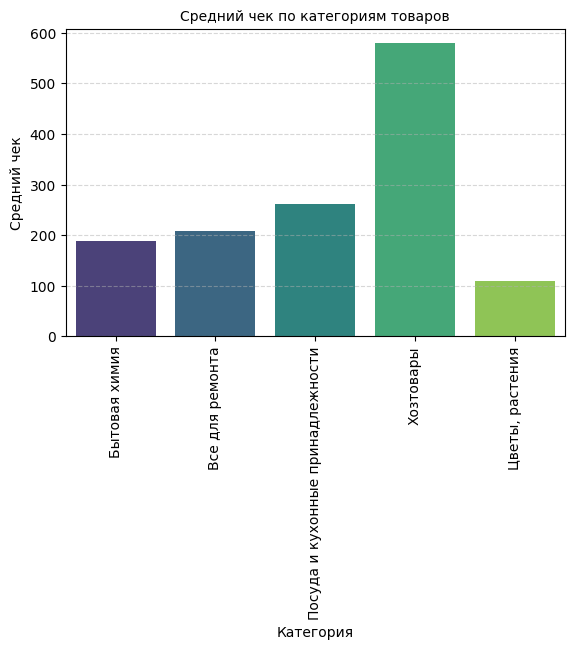

In [449]:
# 2 - построим столбчатую диаграмму, чтобы посмотреть распределение средних чеков

plt.figure(figsize=(6, 4))
sns.barplot(y='average_check',
            x='category',
            data=df_hypothesis,
            palette='viridis',
            legend=False
            )

# Настройка заголовка и подписей осей
plt.title('Средний чек по категориям товаров', fontsize=10)
plt.xlabel('Категория')
plt.ylabel('Средний чек')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=90)
plt.show()

## Формулировка гипотез

In [450]:
df_hypothesis

,category,total,total_sales,average_check
0,Бытовая химия,14379.0,76,189.20
1,Все для ремонта,342013.0,1647,207.66
2,Посуда и кухонные принадлежности,398322.0,1526,261.02
3,Хозтовары,3223828.0,5569,578.89
4,"Цветы, растения",872738.0,8035,108.62


На основе проведенного EDA мложно сформулировать следующие гипотезы:
- признак `category`
    - H_0 -- разница в суммах средних чеков (average_check) по всем категориям статистически незначима;

    - H_1 (двусторонняя) -- разница в суммах средних чеков (average_check) по всем категориям статистически значима.


In [451]:
# проверка гипотез о нормальном распределении величин по категориям

# -- H_0: величина имеет нормальное распределение;
# -- H_1: величина имеет распределение отличное от нормального;

a = sorted_df[sorted_df.category == 'Бытовая химия'].sum_orders
b = sorted_df[sorted_df.category == 'Все для ремонта'].sum_orders
c = sorted_df[sorted_df.category == 'Посуда и кухонные принадлежности'].sum_orders
d = sorted_df[sorted_df.category == 'Хозтовары'].sum_orders
e = sorted_df[sorted_df.category == 'Цветы, растения'].sum_orders


In [452]:
print(f'Для категории "Бытовая химия"')
print()
print(f'{check_hyp(a)}')
print('----------------')
print(f'Для категории "Все для ремонта"')
print()
print(f'{check_hyp(b)}')
print('----------------')
print(f'Для категории "Посуда и кухонные принадлежности"')
print()
print(f'{check_hyp(c)}')
print('----------------')
print(f'Для категории "Хозтовары"')
print()
print(f'{check_hyp(d)}')
print('----------------')
print(f'Для категории "Цветы, растения"')
print()
print(f'{check_hyp(e)}')


Для категории "Бытовая химия"

Критерий Шапиро
Гипотезу H_0 о нормальном распределении x отвергаем.
        Иными словами, распределение сл. величины x отлично от нормального.
        p-value = 1.2232138422798392e-10
None
----------------
Для категории "Все для ремонта"

Критерий Шапиро
Гипотезу H_0 о нормальном распределении x отвергаем.
        Иными словами, распределение сл. величины x отлично от нормального.
        p-value = 7.158448618903452e-16
None
----------------
Для категории "Посуда и кухонные принадлежности"

Критерий Шапиро
Гипотезу H_0 о нормальном распределении x отвергаем.
        Иными словами, распределение сл. величины x отлично от нормального.
        p-value = 2.2604756597754516e-31
None
----------------
Для категории "Хозтовары"

Критерий Шапиро
Гипотезу H_0 о нормальном распределении x отвергаем.
        Иными словами, распределение сл. величины x отлично от нормального.
        p-value = 3.1262753590365264e-52
None
----------------
Для категории "Цветы, растен

In [453]:
print(f'Для категории "Бытовая химия"')
print()
print(f'{check_ks(a)}')
print('----------------')
print(f'Для категории "Все для ремонта"')
print()
print(f'{check_ks(b)}')
print('----------------')
print(f'Для категории "Посуда и кухонные принадлежности"')
print()
print(f'{check_ks(c)}')
print('----------------')
print(f'Для категории "Хозтовары"')
print()
print(f'{check_ks(d)}')
print('----------------')
print(f'Для категории "Цветы, растения"')
print()
print(f'{check_ks(e)}')

Для категории "Бытовая химия"

Критерий Колмогорова-Смирнова
Гипотезу H_0 о нормальном распределении x принимаем.
        Иными словами, распределение сл. величины x нормальное.
        p-value = 0.17045454545454547
None
----------------
Для категории "Все для ремонта"

Критерий Колмогорова-Смирнова
Гипотезу H_0 о нормальном распределении x принимаем.
        Иными словами, распределение сл. величины x нормальное.
        p-value = 0.1668773704171934
None
----------------
Для категории "Посуда и кухонные принадлежности"

Критерий Колмогорова-Смирнова
Гипотезу H_0 о нормальном распределении x принимаем.
        Иными словами, распределение сл. величины x нормальное.
        p-value = 0.15271872902215244
None
----------------
Для категории "Хозтовары"

Критерий Колмогорова-Смирнова
Гипотезу H_0 о нормальном распределении x принимаем.
        Иными словами, распределение сл. величины x нормальное.
        p-value = 0.09377235846615217
None
----------------
Для категории "Цветы, растения"


In [454]:
# воспользуемся ANOVA test для проверки 5 групп данных:
alpha = 0.05
# Выполнение однофакторного дисперсионного анализа
f_statistic, p_value_anova = stats.f_oneway(a, b, c, d, e)

print(f"F-статистика: {f_statistic}")
print(f"P-значение: {p_value_anova}")
print()

# так как проверяются сразу несколько гипотез, нужно сделать коррекцию Бонферрони

num_hypotheses = 5 # количество гипотез
alpha_corr = alpha / num_hypotheses
print(f"Скорректированный уровень значимости (Бонферрони): {alpha_corr}")
print()
if p_value_anova < alpha_corr:
    print('''Отклоняем нулевую гипотезу и принимаем альтернативную:
<<разница в суммах средних чеков (average_check)
по всем категориям статистически значима>>''')
else:
    print("Недостаточно оснований для отклонения нулевой гипотезы.")

F-статистика: 6.072708604514711
P-значение: 7.364673916302414e-05

Скорректированный уровень значимости (Бонферрони): 0.01

Отклоняем нулевую гипотезу и принимаем альтернативную:
<<разница в суммах средних чеков (average_check)
по всем категориям статистически значима>>


##Вывод по результатам проверки гипотез:

- разница в суммах средних чеков по выделенным категориям является статистически значимой.

# Результат исследования

В ходе выполнения работы:

- была проведена предобработка данных, добавлены новые признаки;
- исследованы аномальные значения и построены графики по ним;

- отдельно рассмотрены данные очищенные от аномалий, а также данные по крупным заказам (с помощью визуализации);

- проведен анализ товарного ассортимента, где были выделены категории товаров: 'Цветы, растения', 'Хозтовары', 'Посуда и кухонные принадлежности',
       'Все для ремонта', 'Бытовая химия';
       а также в каждой категории товары были распределены на Основной
       и Дополнительный ассортимент на основании ABC-анализа;

- сформулированы статистические гипотезы о равенстве средних чеков по выделенным категориям, в ходе проверки которых, подтвердилось, что разница средних чеков статистически значима;


- на основе полученных данных был построен дашборд для наглядности распределения значений по категориям.